In [ ]:
import matplotlib.pyplot as plt
from google.colab import files
from tensorflow import keras
import tensorflow as tf
import numpy as np
import zipfile
import shutil
import json
import os

In [ ]:
image_size = 224
target_size = (image_size, image_size)
input_shape = (image_size, image_size, 3)
batch_size = 32
epochs = 25

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/ufvfolder/psvillageds.zip -d /content/

In [ ]:
!rm -r input
!mkdir input

In [ ]:
def copy_images(source_dir, destination_dir, num_images):
    # Get a list of all files in the source directory
    files = os.listdir(source_dir)
    cnt = 0
    # Copy the specified number of images to the destination directory
    for i, image_file in enumerate(files[:num_images]):
        source_path = os.path.join(source_dir, image_file)
        destination_path = os.path.join(destination_dir, image_file)
        shutil.copy2(source_path, destination_path)
        # print(destination_path)
        cnt+=1

    print(f"{cnt} images in {source_dir} copied.")

# Example usage
source_directory = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/'
destination_directory = '/content/input/'
num_images_to_copy = 570

folders = [folder for folder in os.listdir(source_directory) if os.path.isdir(os.path.join(source_directory, folder))]

for folder in folders:
    # print(source_directory+"/"+folder)
    copy_images(source_directory+folder, destination_directory, num_images_to_copy)


In [1]:
def zip_folder(folder_path, output_path):
    with zipfile.ZipFile(output_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                zipf.write(file_path, arcname=os.path.relpath(file_path, folder_path))

folder_path = '/content/input'  # Replace with the path to your folder
output_path = '/content/myinput.zip'  # Replace with the desired output path

zip_folder(folder_path, output_path)
print("Folder zipped successfully.")

Folder zipped successfully.


In [ ]:
from google.colab import files

# Specify the path to the zip file
zip_file_path = '/content/myinput.zip'  # Replace with the actual path of the zip file

# Download the zip file
files.download(zip_file_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
base_dir = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = os.path.join(base_dir,"train")
test_dir = os.path.join(base_dir,"valid")

In [ ]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0,
                                                             shear_range = 0.2,
                                                             zoom_range = 0.2,
                                                             width_shift_range = 0.2,
                                                             height_shift_range = 0.2,
                                                             fill_mode="nearest")

test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0)

In [ ]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size = (image_size, image_size),
                                               batch_size = batch_size,
                                               class_mode = "categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = (image_size, image_size),
                                             batch_size = batch_size,
                                             class_mode = "categorical")

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [ ]:
categories = list(train_data.class_indices.keys())
print(train_data.class_indices)

{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___Late_blight': 30, 'Tomato

In [ ]:
with open('class_indices.json','w') as f:
  json.dump(train_data.class_indices, f)

from IPython.display import FileLink
FileLink(r'class_indices.json')

/content/class_indices.json

In [ ]:
base_model = tf.keras.applications.MobileNet(weights = "imagenet",
                                             include_top = False,
                                             input_shape = input_shape)

base_model.trainable = False

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
inputs = keras.Input(shape = input_shape)

x = base_model(inputs, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(len(categories),
                          activation="softmax")(x)

model = keras.Model(inputs = inputs,
                    outputs = x,
                    name="LeafDisease_MobileNet")

In [ ]:
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer = optimizer,
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
              metrics=[keras.metrics.CategoricalAccuracy(),
                       'accuracy'])

In [ ]:
history = model.fit(train_data,
                    validation_data=test_data,
                    epochs=epochs,
                    steps_per_epoch=150,
                    validation_steps=100)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


150/150 [==============================] - 91s 535ms/step - loss: 1.9518 - categorical_accuracy: 0.4896 - accuracy: 0.4896 - val_loss: 0.7837 - val_categorical_accuracy: 0.8003 - val_accuracy: 0.8003
Epoch 2/25
150/150 [==============================] - 76s 506ms/step - loss: 0.7662 - categorical_accuracy: 0.7867 - accuracy: 0.7867 - val_loss: 0.5035 - val_categorical_accuracy: 0.8681 - val_accuracy: 0.8681
Epoch 3/25
150/150 [==============================] - 75s 502ms/step - loss: 0.5537 - categorical_accuracy: 0.8402 - accuracy: 0.8402 - val_loss: 0.4150 - val_categorical_accuracy: 0.8844 - val_accuracy: 0.8844
Epoch 4/25
150/150 [==============================] - 77s 511ms/step - loss: 0.4676 - categorical_accuracy: 0.8652 - accuracy: 0.8652 - val_loss: 0.3387 - val_categorical_accuracy: 0.9009 - val_accuracy: 0.9009
Epoch 5/25
150/150 [==============================] - 74s 492ms/step - loss: 0.4059 - categorical_accuracy: 0.8808 - accuracy: 0.8808 - val_loss: 0.2932 - val_categori

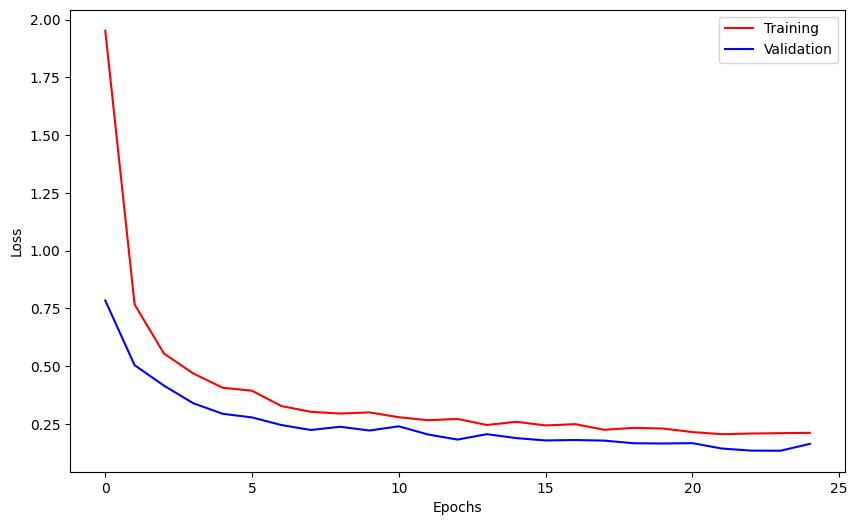

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

fig = plt.figure(figsize=(10,6))
plt.plot(epochs,loss,c="red",label="Training")
plt.plot(epochs,val_loss,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

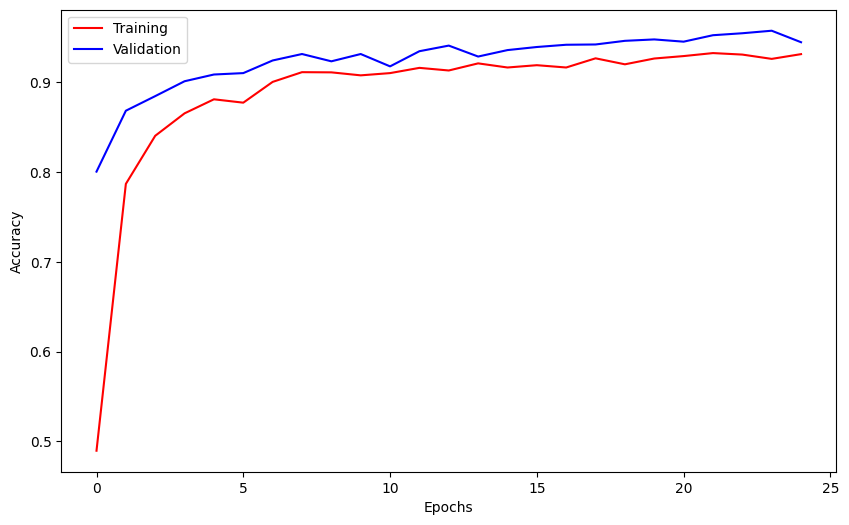

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

epochs = range(len(acc))

fig = plt.figure(figsize=(10,6))
plt.plot(epochs,acc,c="red",label="Training")
plt.plot(epochs,val_acc,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [ ]:
model.save('plant_disease')

In [ ]:
!zip -r /content/plant_disease.zip /content/plant_disease
files.download("/content/plant_disease.zip")

  adding: content/plant_disease/ (stored 0%)
  adding: content/plant_disease/fingerprint.pb (stored 0%)
  adding: content/plant_disease/keras_metadata.pb (deflated 96%)
  adding: content/plant_disease/assets/ (stored 0%)
  adding: content/plant_disease/saved_model.pb (deflated 91%)
  adding: content/plant_disease/variables/ (stored 0%)
  adding: content/plant_disease/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/plant_disease/variables/variables.index (deflated 75%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>